**HWRS 582 GHW2: Recharge (with looping)**

*MODFLOW files used:*
   <br>DIS - Discretization input
   <br>BAS - Basic
   <br>LPF - Layer-Property Flow
   <br>OC  - Output Control
   <br>PCG - Preconditioned Conjugate Gradient
   <br>RCH - Recharge
    
*Model description:*
<br>Build a steady state box model.  The model should have 25x25 cells, each 100 m in x and in y.  There is one layer, 10 m thick.  The medium is homogeneous with K = 1.0 m/day in x and y and 0.1 m/day in z.  The porosity is 0.35, specific yield is 0.3, and storage coefficient is 0.001.  The right boundary is zero flux, representing a closed basin.  The left boundary is a constant head of 7 m relative to the datum, which is located at the bottom of the domain. Build two models.  The first has uniform recharge at a rate of 5E-6 m/d over the entire domain (as defined for self check assignment 2). For the second model, recharge occurs only over the rightmost 20% of the domain; it is zero elsewhere.  Adjust the recharge such that has the total inflow into the second model is identical to that into the first model. n (Hint: use the mass balance and adjust the recharge rate to match the first model!)  Add particles at three levels within the layer along the left boundary.  Using reverse particle tracking, determine the distance between the point at which particles enter the domain and the right boundary for each of these depths for each model.

**Import Python packages**

In [15]:
#Import FloPy:
import flopy

#Import analysis & plotting tools:
import numpy as np
import flopy.utils.binaryfile as bf
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

**Model setup**

In [16]:
#Define model parameters:
##Model grid:
nrow = 25          #number of rows
ncol = 25          #number of columns
nlay = 1           #number of layers
delr = 100.        #width of each cell along rows (so really this is column width along x axis)
delc = 100.        #width of each cell along columns (so really this is row height along y axis)
Lx = ncol*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc     #width of domain in y (across rows) = number of rows x cell height
ztop = 10.         #top elevation
zbot = 0.          #bottom elevation
#delr = Lx/ncol    #cell width along the rows - if defining total model width uncomment this and comment out lines 47 & 48
#delc = Ly/nrow    #cell width along the columns
delv = (ztop - zbot) / nlay     #cell height in z axis
botm = np.linspace(ztop, zbot, nlay + 1) #bottom elevation of each layer - linspace generates an array of nlay+1 linearly spaced values between ztop and zbot

##Medium properties:
K_horiz = 1.    #assign horizontal hydraulic conductivity (along rows)
K_ratio = 1.    #assign ratio of Ky/Kx (aka Kcol/Krow)
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield

#Confined/unconfined?:
uncnf = 1      #0=confined, >0 = unconfined

##Boundary conditions:
#Constant head:
#if ibound < 0, constant head, if = 0, inactive, if > 0 active.
#create arrays to indicate active cells (ibound) and starting heads (H_init):
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)    #integer array of dim (z,y,x), makes all cells active                                                     
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
#set head at left boundary:
H_left = 7.                 #define constant head value of 7m
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
H_init[:, :, 0] = H_left    #replace first (left) col with desired head value

##Recharge:
nscen = 2                            #number of different recharge scenarios
rech = np.zeros((nscen,nrow,ncol))   #define an array of zeros of dim (nscen,nrow,ncol)
rech[0,:,:] = 5e-6                   #define uniform recharge flux (m/day) for 1st scenario
rech[0,:,20:25] = 2.4e-5             #define zonal recharge flux (m/day) for 2nd scenario


#Print model summary:
print("Model name: ", modelname)
text = '''Model grid: {} layer x {} rows x {} cols;  Cell dimensions: {}m x {}m x {}m
Parameters: Kx = {}m/d, Ky = {}m/d, Kz = {}m/d
n = {}, Sy = {}, S = {}'''
print(text.format(nlay,nrow,ncol, delv,delr,delc, K_horiz,K_horiz,K_vert, n,Sy,Ss))

Model name:  GHW2
Model grid: 1 layer x 25 rows x 25 cols;  Cell dimensions: 10.0m x 100.0m x 100.0m
Parameters: Kx = 1.0m/d, Ky = 1.0m/d, Kz = 0.1m/d
n = 0.35, Sy = 0.3, S = 0.001


**Create package objects & write MODFLOW input files**

In [17]:
#Clear input files from last model run (optional: change run to 'y' to run):
run = 'n'
if run == 'y':
    file_extensions = ['dis','bas','lpf','oc','pcg','rch']
    for ext in file_extensions:
        os.remove('GHW2.'+ext)
    

In [18]:
#For two different recharge scenarios:

for scenario in [0,1]:
    #Create model object:
    modelname = "GHW2"+str(scenario)          #Names model based on scenario
    mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe    
    
    #Create objects for each package (see GHW1 notebook for details):
    dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, 
                               delc=delc, top=ztop, botm=botm[1:])         #DIS (Discretization): creates model grid   
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=H_init)         #BAS (Basic): assigns head boundaries
    lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=K_vert, 
                               ss=Ss, sy=Sy,storagecoefficient=True, ipakcb=53) #LPF (Layer Property Flow): assigns flow props between cells
    spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
    oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)  #OC (Output Control): Decides what outputs to save
    pcg = flopy.modflow.ModflowPcg(mf)                                      #PCG (Preconditioned Conjugate Gradient)
    rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech[scenario,:,:])       #RCH (Recharge)
    
    #Write MODFLOW input files:
    mf.write_input()
    
    #Run MODFLOW:
    success, buff = mf.run_model()
    

FloPy is using the following executable to run the model: mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: GHW20.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/02/10 16:09:49

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/02/10 16:09:49
 Elapsed run time:  0.009 Seconds

  Normal termination of simulation
FloPy is using the following executable to run the model: mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: GHW21.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/02/10 16:09:49

 Solving:  Stress period:     1   

**Post-process results**

In [19]:
for scenario in [0,1]:
    #Get outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the binary head file
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
         #string options are in the list file under output control (make sure to include spaces!)

C:\Users\Chloe\Anaconda3\envs\HWR582\lib\site-packages\flopy\utils\binaryfile.py:756: FutureWarning: Assignment between structured arrays with different field names will change in numpy 1.14.

Previously fields in the dst would be set to the value of the identically-named field in the src. In numpy 1.14 fields will instead be assigned 'by position': The Nth field of the dst will be set to the Nth field of the src array.

See the release notes for details
  header2 = header2.astype(self.header2_dtype)


In [20]:
#Print outputs to reality-check (optional: change run to 'y' to run)
run = 'y'
if run == 'y':
    print('timesteps:', times)         
    print('final head:', 'dimensions', np.shape(head), '\n', head)    
    print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
    print('recharge zone 2:', 'dimensions', np.shape(rech_zone),'\n',rech_zone)


timesteps: [1.0]
final head: dimensions (1, 25, 25) 
 [[[ 7.          6.99999952  6.99999905  6.99999905  6.99999905  6.99999905
    6.99999905  6.99999905  6.99999952  7.          7.          6.99999952
    6.99999952  6.99999952  7.          7.00000095  7.00000143  7.00000191
    7.00000191  7.00000238  7.00000238  7.00000286  7.00000286  7.00000286
    7.00000286]
  [ 7.          6.99999952  6.99999952  6.99999952  6.99999952  6.99999952
    6.99999952  6.99999952  6.99999952  7.          7.          6.99999952
    6.99999952  7.          7.00000048  7.00000095  7.00000143  7.00000191
    7.00000191  7.00000238  7.00000286  7.00000286  7.00000286  7.00000286
    7.00000238]
  [ 7.          6.99999952  6.99999952  6.99999952  7.          7.          7.
    7.          7.          7.          7.          7.          7.          7.
    7.00000048  7.00000095  7.00000143  7.00000143  7.00000191  7.00000191
    7.00000238  7.00000238  7.00000238  7.00000238  7.00000238]
  [ 7.          6

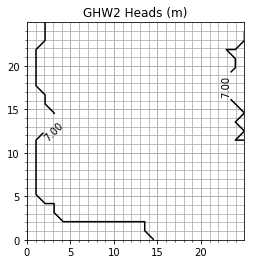

In [21]:
#Plot contour map of heads in Layer 1:

#Create figure & plot data:
fig1 = plt.figure()                     #create figure and return a figure object
ax1 = plt.subplot(1,1,1, aspect='equal') #in current figure, create & return axes at position (row, col, index)
levels = np.arange(1,10,0.25)  #creates an array of values from 1 to 9 with a step size of 1, used to determine which contour values to draw
extent = (0, ncol, 0, nrow)              #sets plot boundaries (x0,x1,y0,y1)
c = plt.contour(head[0,:,:], extent=extent, levels=levels, colors='k')  #plots contours for all rows & columns in layer 1

#Format grid & axes:
major_ticks = np.arange(0,25,5)         #creates an array for major tick marks every 5
minor_ticks = np.arange(0,25)           #creates an array for minor tick marks every 1

ax1.set_xticks(major_ticks)             #sets major ticks
ax1.set_xticks(minor_ticks, minor=True) #sets minor ticks
ax1.set_yticks(major_ticks)
ax1.set_yticks(minor_ticks, minor=True)

ax1.grid(which='both')                  #turns grid on for both major and minor ticks

#Labels:
plt.clabel(c, fmt='%1.2f')              #adds contour labels as floats with 2 decimal places       
plt.title('GHW2 Heads (m)')             #adds a title

#Save figure:
plt.savefig('GHW2_head_contours.png')    #optional: saves figure as a .png file

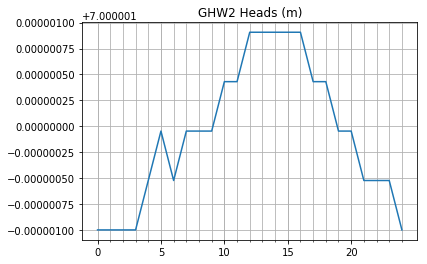

In [22]:
#Plot cross-section of heads along center row:

#Create figure & plot data:
fig1b = plt.figure()                     #create figure and return a figure object
ax1b = plt.subplot(1,1,1)                #in current figure, create & return axes at position (row, col, index)
plt.plot(np.arange(ncol), head[0,12,:]) #plots heads at layer 0, row 12, all columns

#Format grid & axes:
major_ticks = np.arange(0,25,5)         #creates an array for major tick marks every 5
minor_ticks = np.arange(0,25)           #creates an array for minor tick marks every 1

ax1b.set_xticks(major_ticks)             #sets major ticks
ax1b.set_xticks(minor_ticks, minor=True) #sets minor ticks

ax1b.grid(which='both')                  #turns grid on for both major and minor ticks   
plt.title('GHW2 Heads (m)')             #adds a title

#Save figure:
plt.savefig('GHW2_head_xsec.png')    #optional: saves figure as a .png file

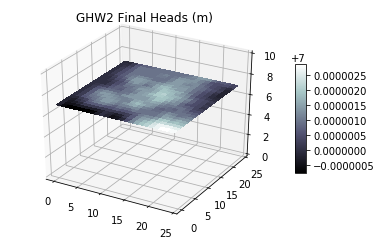

In [23]:
#Plot a 3D surface of the water table (optional: set run to 'y' to run this section)

run = 'y'
if run == 'y':
    #Create data arrays to plot
    X = np.arange(25)         #create an array of x values corresponding to model columns
    Y = np.arange(25)         #create an array of y values corresponding to model rows
    X, Y = np.meshgrid(X, Y)  #create a 2D grid for X and Y values
    Z = head[0,:,:]           #assign heads as Z values
    
    #Plot surface:
    fig2 = plt.figure()               #create figure object
    ax2 = fig2.gca(projection='3d')   #set 3D axes
    surf = ax2.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.bone, linewidth=0, antialiased=False)     #plot surface
    
    #Format plot:
    fig2.colorbar(surf, shrink=0.5, aspect=10)   #display colorbar for surface
    ax2.set_zlim(zbot,ztop, delv)                #set axis limits & spacing
    plt.title('GHW2 Final Heads (m)')            #add title
    
    #Optional extra formatting specifications (uncomment to run):
    #ax3.set_xlim(0,Lx, delr)
    #ax3.set_ylim(0,Ly, delc)
    #plt.locator_params(axis='z', nbins=nlay)    #set axis step size
    #plt.locator_params(axis='y', nbins=nrow)
    #plt.locator_params(axis='x', nbins=ncol)

    fig2.savefig('GHW2_head_surface.png')       #save figure as a png

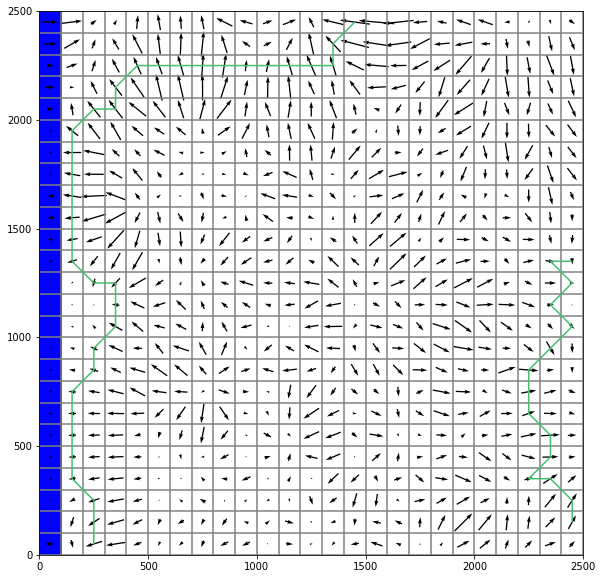

In [24]:
#Plot boundary conditions, grid, head contours, and flow vectors using ModelMap class:
#This makes a plan view contour map of the water table with flow vectors & grid cells
#(optional: set run to 'y' to run this section)

run = 'y'
if run == 'y':
    fig3 = plt.figure(figsize=(10,10))            #creates figure object
    ax3 = fig3.add_subplot(1,1,1,aspect='equal')  #creates axes object
    levels = np.linspace(0,10,11)                 #sets which contours levels to plot
    modelmap = flopy.plot.ModelMap(model=mf, layer=0)
    qm = modelmap.plot_ibound()                             #plots constant head boundary conditions
    lc = modelmap.plot_grid()                               #plots the grid lines
    cs = modelmap.contour_array(head, levels=levels)        #makes a contour plot of heads
    quiver = modelmap.plot_discharge(frf, fff, head=head)   #plots flow vectors
    plt.savefig('GHW2_vectors.png')                         #saves figure as png

**Export & compare data**

In [25]:
#Export an array to a CSV file:
import csv                                              #import csv module (this DOESN'T import an actual csv file)
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')        
    for i in range(len(head[0,:,0])):                    #writes each row
        writer.writerow(head[0,i,:])
        
#Import a CSV file and convert to an array:
#This is useful for checking to see if the head distribution matches what GWV generated
#The GWV head file must first be placed in the same folder as this Python file
#Change run to "y" to run this section
run = "y"
if run == "y":
    #Import head array from GWV csv file:
    import csv                     #import csv module
    name = "GWV_heads_zone.csv"        #name of csv file to import
    GWVheads = np.zeros([nrow,ncol])   #create array of zeros to store heads in
    with open(name, newline='') as csvfile:   #open csv file & start reading
        reader = csv.reader(csvfile)
        i = 0                           #initialize counter
        for row in reader:              #iterate over rows
            GWVheads[i,:] = row         #store heads for each row in array
            i = i + 1                   #advance counter by one

RMSE =  1.99628016165 m


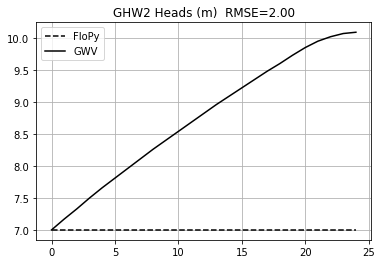

In [26]:
#Check to see how well GroundWater Vistas heads match FloPy heads:

#Calculate root mean square error between two datasets:
run = 'y'
if run == 'y':
    
    #Define RMSE function
    def rmse(predictions, targets):                                    #function_name(input1, input2)
        return np.sqrt(((predictions - targets) ** 2).mean())          #output

    #Find RMSE between FloPy and GWV results
    RMSE = rmse(head[0,:,:], GWVheads)               #call rmse function on FloPy head array & GWV head array
    print("RMSE = ",RMSE, "m")                       #print results
    
#Plot GWV head profile against FloPy head profile:
run = 'y'
if run == 'y':
    
    #Create figure & plot data:
    fig4 = plt.figure()                        #create figure and return a figure object
    ax4 = plt.subplot(1,1,1)                   #in current figure, create & return axes at position (row, col, index)
    plt.plot(np.arange(ncol), head[0,12,:], 'k--')   #plots FloPy heads at lay 0, row 12, all cols, as black dashed line
    plt.plot(np.arange(ncol), GWVheads[12,:], 'k-')  #plots GWV heads at row 12, all columns, as black line

    #Format grid & axes:
    major_ticks = np.arange(0,25,5)         #creates an array for major tick marks every 5
    minor_ticks = np.arange(0,25)           #creates an array for minor tick marks every 1

    ax1b.set_xticks(major_ticks)             #sets major ticks
    ax1b.set_xticks(minor_ticks, minor=True) #sets minor ticks

    ax4.grid(which='both')                  #turns grid on for both major and minor ticks
    ax4.legend(['FloPy','GWV'])
    plt.title('GHW2 Heads (m)  RMSE=' + '%.2f'%RMSE)    #adds a title with the RMSE to 2 decimal places 

    #Save figure:
    plt.savefig('GHW2_GWV_v_FP.png')    #optional: saves figure as a .png file